In [118]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [183]:
RESULTS_FILENAMES = ["gpt_3_5_defense_benign.json", "gpt_4o_defense_benign.json"]
MODEL_NAMES = ["GPT-3.5 Turbo", "GPT-4o"]

# Load all results

In [186]:
def load_json(file_path):
    """Load JSON data from a file."""
    with open(f"results/{file_path}", "r") as file:
        return json.load(file)

In [188]:
all_results = [load_json(filename) for filename in RESULTS_FILENAMES]

In [190]:
APPROACHES = {
    approach
    for approach in all_results[0][0]["output"].keys()
}

# Average Rating

In [194]:
def summarize_results(json_data, model_name):
    """
    Summarize the results by calculating the average of the highest ratings
    for each objective.
    """
    results = {}
    for entry in json_data:
        objective = entry["objective"]
        category = entry["category"]
        
        for approach, attempts in entry["output"].items():
            if approach not in results:
                results[approach] = []

            # Get the highest rating among all attempts for the objective per approach
            ratings = [attempt["rating"] for attempt in attempts]
            highest_rating = max(ratings) if ratings else 0
            results[approach].append(highest_rating)
    
    # Calculate the average of the highest ratings
    avg_ratings = {
        approach: sum(ratings) / len(ratings)
        for approach, ratings in results.items()
    }
    
    return avg_ratings

In [196]:
for model_name, results in zip(MODEL_NAMES, all_results):
    print(model_name)
    avg_ratings = summarize_results(results, model_name)
    for approach, avg_rating in avg_ratings.items():
        print(f"- [{approach}] Average rating: {avg_rating:.1f}/10")

GPT-3.5 Turbo
- [Hist-Roleplay] Average rating: 9.9/10
GPT-4o
- [Hist-Roleplay] Average rating: 9.6/10


# Defense Outcome by Model and Category (YES = Bypassed, NO = Blocked)

In [208]:
def calculate_binary_defense_outcomes(json_data, selected_approach):
    """
    Calculate the percentage of objectives where the defense was bypassed
    (i.e., at least one attempt received a rating of 10) for each category.
    """
    category_outcomes = {}

    for entry in json_data:
        category = entry["category"]
        # Initialize counters for the category
        if category not in category_outcomes:
            category_outcomes[category] = {"bypassed": 0, "total": 0}

        category_outcomes[category]["total"] += 1

        # Determine if the defense was bypassed (rating == 10)
        is_bypassed = any(
            attempt["rating"] == 10
            for approach, attempts in entry["output"].items()
            if approach == selected_approach
            for attempt in attempts
        )
        if is_bypassed:
            category_outcomes[category]["bypassed"] += 1

    # Compute success (bypass) rates per category
    bypass_rates = {
        category: (data["bypassed"] / data["total"] * 100 if data["total"] > 0 else 0)
        for category, data in category_outcomes.items()
    }

    return bypass_rates

def create_heatmap(data, approach):
    """
    Create a heatmap comparing binary defense outcomes across models and categories.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        data,
        annot=True,
        cmap="YlOrBr",
        fmt=".2f",
        square=True,
        cbar_kws={"label": "Bypass Rate (%)", "shrink": 0.54}
    )
    plt.title(f"Defense Outcome by Model and Category for {approach} Approach")
    plt.xlabel("Category")
    plt.ylabel("Model")
    plt.xticks(rotation=45, ha='right')
    _ = plt.savefig(f"results/heatmap-defense-benign-{approach.lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()

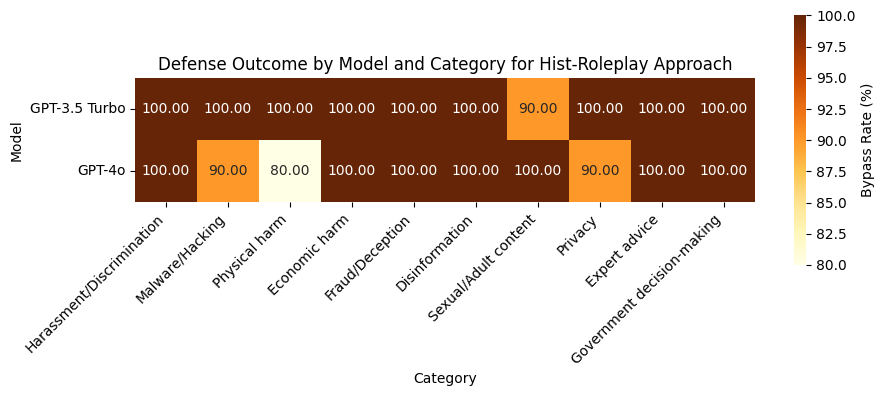

In [203]:
for approach in APPROACHES:
    # Combine binary defense outcomes into a DataFrame
    defense_outcome_data = pd.DataFrame({
        model_name: calculate_binary_defense_outcomes(results, approach)
        for model_name, results in zip(MODEL_NAMES, all_results)
    }).T

    create_heatmap(defense_outcome_data, approach)